In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn as sk

In [64]:
from jupyterthemes import jtplot
jtplot.style()

In [65]:
data = pd.read_csv("creditcard.csv")

### Dataset/Project Overview

This dataset contains European creadit card transactions in the year 2013. It contains 284807 rolls of credit card transaction. 

###### Benefits

Using this dataset, we will develop a machine learning classifier that detects any fraud transaction. This can benefits credit card users and banks by detecting fraud transactions automatically. <br><br>
Credit card fraud department can also implement this kind of machine learning classifier on other kinds of credit card, saving labor and time.

###### Objective

In order to achieve the benefits mentioned above, the classifier needs to be accurate and predict the result in a timely manner. 

Aside from accuracy, we need to take false positive and false negative into account. <br>
False Positive: Legit transaction counts as fraud transaction<br>
False Positive: Fraud transaction counts as legit transaction<br>

As a result, more than one measurement should be used to determine the best model.


###### Measurement

Because false positive and false negative is a big factor for building the classifer, using confustion matrix would be the most appropriate tool to show the results. It can also be a tool to tune any parameters

Additionaly, F1 score can be a measurement for the classifiers.

### Data exploration

Out of all the transaction, there are 492 fraud transation, which is less than 2% of the dataset.

In [66]:
data.shape

(284807, 31)

A time column shows the number of seconds elasped between each transaction and the first transaction in the dataset. <br><br>
There are 28 columns in the dataset that were transaformed with PCA. The use of PCA in this case is not exactly dimensionality reduction but rather protection of confidential information. <br><br>
A amount column shows the transaction amount. 

In [67]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

The label column is a binary variable that records frauad trasaction in 1 being fraud and 0 being a normal transaction. 

In [68]:
data.Class.unique()

array([0, 1], dtype=int64)

Check for missing data <br>
There are no missing data

In [69]:
data.isnull().sum().any()

False

##### Use non-PCA variable to look at normal vs fraud

In [70]:
normal = data[data['Class'] == 0]
fraud = data[data['Class'] == 1]

There is only 0.17% of fraud transaction in the dataset.

In [71]:
fraud_count = len(data[data['Class'] == 1])
perct = len(data[data['Class'] == 1])/len(data) * 100
print("There are {} fraud transaction which is {:.2f} %" .format(fraud_count, perct) )

There are 492 fraud transaction which is 0.17 %


The histogram shows how imbalance the two variable are.

Text(0, 0.5, '# of Transaction')

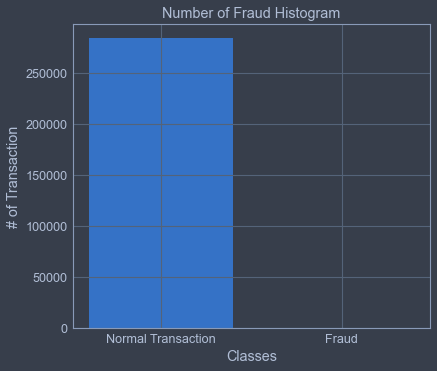

In [72]:
class_count = pd.value_counts(data['Class'])
x = ['Normal Transaction', 'Fraud']
y = class_count.values
# plt.bar(class_count.index. class_count.values)
plt.bar(x,y)
plt.title("Number of Fraud Histogram")
plt.xlabel("Classes")
plt.ylabel("# of Transaction")

Because of the how imbalance the dataset is, training an algorithm with this dataset may have a bias towards normal transaction. <br> It needs to be resampled to a balanced dataset.

### Dataset resampling

There are different resampling techniques for imbalance dataset. This particular dataset has a large number of normal transaction rows and not so large fraud transaction rows. <br><br> I decide to bring down the number of normal transaction rows to equal the number of fraud transaction rows. <br> This is also called under sampling.

To perform under sampling, I decide to use a library called imblearn. It contains different imbalance dataset sampling techniques. One of the undersampling module called Near Miss takes both major class (Normal transaction) and minority classes into account (Fraud transaction), instead of just randomly selecting the major class rows. <br>

Near Miss select rows based on the distance between the rows of major class and minor class. There are 3 version of this: <br>
1 - select major class rows with minimum average distance to 3 closest minor class rows. <br>
2 - select major class rows with minimum average distance to 3 furthest minor class rows. <br>
3 - select major class rows with minimum distance to each minor class row. <br>

The default version of NearMiss is version 3, and I will leave it as is.

In [73]:
import imblearn
from imblearn.under_sampling import NearMiss

##### Define Dataset

In [74]:
X = data[data.columns[0:30]]
y = data[['Class']]

In [75]:
normal = data[data['Class'] == 0]
fraud = data[data['Class'] == 1]
print("There are {} of normal rows and {} of fraud rows".format(len(normal), len(fraud)))

There are 284315 of normal rows and 492 of fraud rows


In [76]:
#NearMiss undersampling method using default parameters
nearmiss = NearMiss()
#perform undersampling
x_adj, y_adj = nearmiss.fit_resample(X,y)
#append the column and labels to a single dataframe
sampled_data = pd.concat([x_adj, y_adj], axis = 1)

In [77]:
#avoid index won't be use in training data, I shuffle the sampled_data to avoid bias in later training
shuffled = sampled_data.sample(frac=1).reset_index(drop=True)

In [78]:
#Check if the dataset is now "balanced"
normal = shuffled[shuffled['Class'] == 0]
fraud = shuffled[shuffled['Class'] == 1]
print("There are {} of normal rows and {} of fraud rows".format(len(normal), len(fraud)))

There are 492 of normal rows and 492 of fraud rows


With the NearMiss sampler, it sample all the normal transaction for the first 492 rows and fraud transactions for the last 492 rows. <Br>

From the resampled data the amount of fraud transactions have more high amount transaction

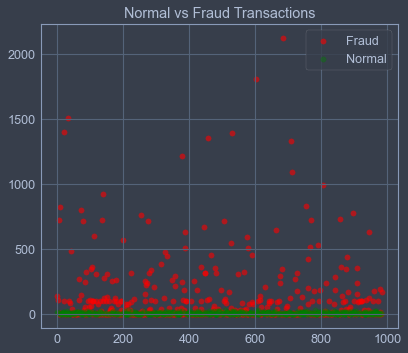

In [79]:
#pull out the Amount column
normal_amount = normal.Amount
fraud_amount = fraud.Amount

plt.title("Normal vs Fraud Transactions")

plt.scatter(fraud_amount.index, fraud_amount, marker='o', alpha=.6, color = "red", label = "Fraud")
plt.scatter(normal_amount.index, normal_amount, marker='o', alpha=.4, color = "green", label = "Normal")
plt.legend(loc="upper right")
plt.show()

### Building the classifiers

Now we have a balanced dataset, let's build different classifier and use cross validation on the original dataset to see which classifier has the performance. I chose Logistic regression, SVM, and Naive Bayes classifier for this topic. <br>
I have the high hope for Naive Bayes classifier as we spent quite some time learning it.

##### Logistic Regression

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [81]:
#Split preprocessed data into X and y
X = shuffled[shuffled.columns[0:30]]
y = shuffled[['Class']]['Class'].values

In [82]:
#Split data into train and label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=123)
print("Rows of training data: {}".format(len(X_train)))
print("Rows of labeled data: {}".format(len(X_test)))

Rows of training data: 688
Rows of labeled data: 296


In [83]:
c_range = [0.001, 0.01, 0.1, 1, 10 , 100]

In [84]:
#build a 10-fold logistic regression with above range of regularization range.
#skelarn would select the best model for the with the best c.
logit_model = LogisticRegressionCV(Cs = c_range, cv = 10,  random_state= 123, max_iter=100)
logit_model.fit(X_train, y_train)
predicted = logit_model.predict(X_test)

c:\environment\analysis\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [85]:
#confusion matrix
matrix = confusion_matrix(y_test, predicted)
print(matrix)

[[152   3]
 [ 11 130]]


 The confusion matrix shows the model did not detect 12 fraud transaction and flasly detect 4 normal transaction as fraud transaction.

In [86]:
#summary report of precision, recall, F1-score, and support
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       155
           1       0.98      0.92      0.95       141

    accuracy                           0.95       296
   macro avg       0.95      0.95      0.95       296
weighted avg       0.95      0.95      0.95       296



The logistic regression model output a respectable F1 score of above 0.95 for both for normal transaction and fraud transaction. 

##### SVM

In [87]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [88]:
kernal_list = ['linear', 'poly', 'rbf', 'sigmoid']

In [89]:
for ker in kernal_list:
    svm_model = SVC(kernel=ker,  random_state= 123)
    svm_model.fit(X_train, y_train)
    accuracy = cross_val_score(svm_model, X_test, y_test, cv=3)
    print( "The {} model has an accuracy of {}".format(ker, np.mean(accuracy)))

The linear model has an accuracy of 0.8513364941936371
The poly model has an accuracy of 0.5878856593142308
The rbf model has an accuracy of 0.49996564282278566
The sigmoid model has an accuracy of 0.564282278567993


In [90]:
#Looks like linear kernel is the best one out of all SVC kernels
svm_model = SVC(kernel='linear',  random_state= 123)
svm_model.fit(X_train, y_train)
#train and predict the test result
predicted = svm_model.predict(X_test)

In [91]:
matrix = confusion_matrix(y_test, predicted)
print(matrix)

[[153   2]
 [ 21 120]]


In [92]:
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       155
           1       0.98      0.85      0.91       141

    accuracy                           0.92       296
   macro avg       0.93      0.92      0.92       296
weighted avg       0.93      0.92      0.92       296



SVC model does not perform very well for this dataset. The F-1 score is below 0.90 which is worse than logistic regression.

##### Naive Bayes classifier

For Naive Bayes classifier, I decide to use the most popular Gaussian Naive Bayes. As the name of the model, the likelihood of the features is assumed to be Gaussian.  <br>
To make sure the features has a Gaussian density, let's make density plots for all the features.

<Figure size 460.8x403.2 with 0 Axes>

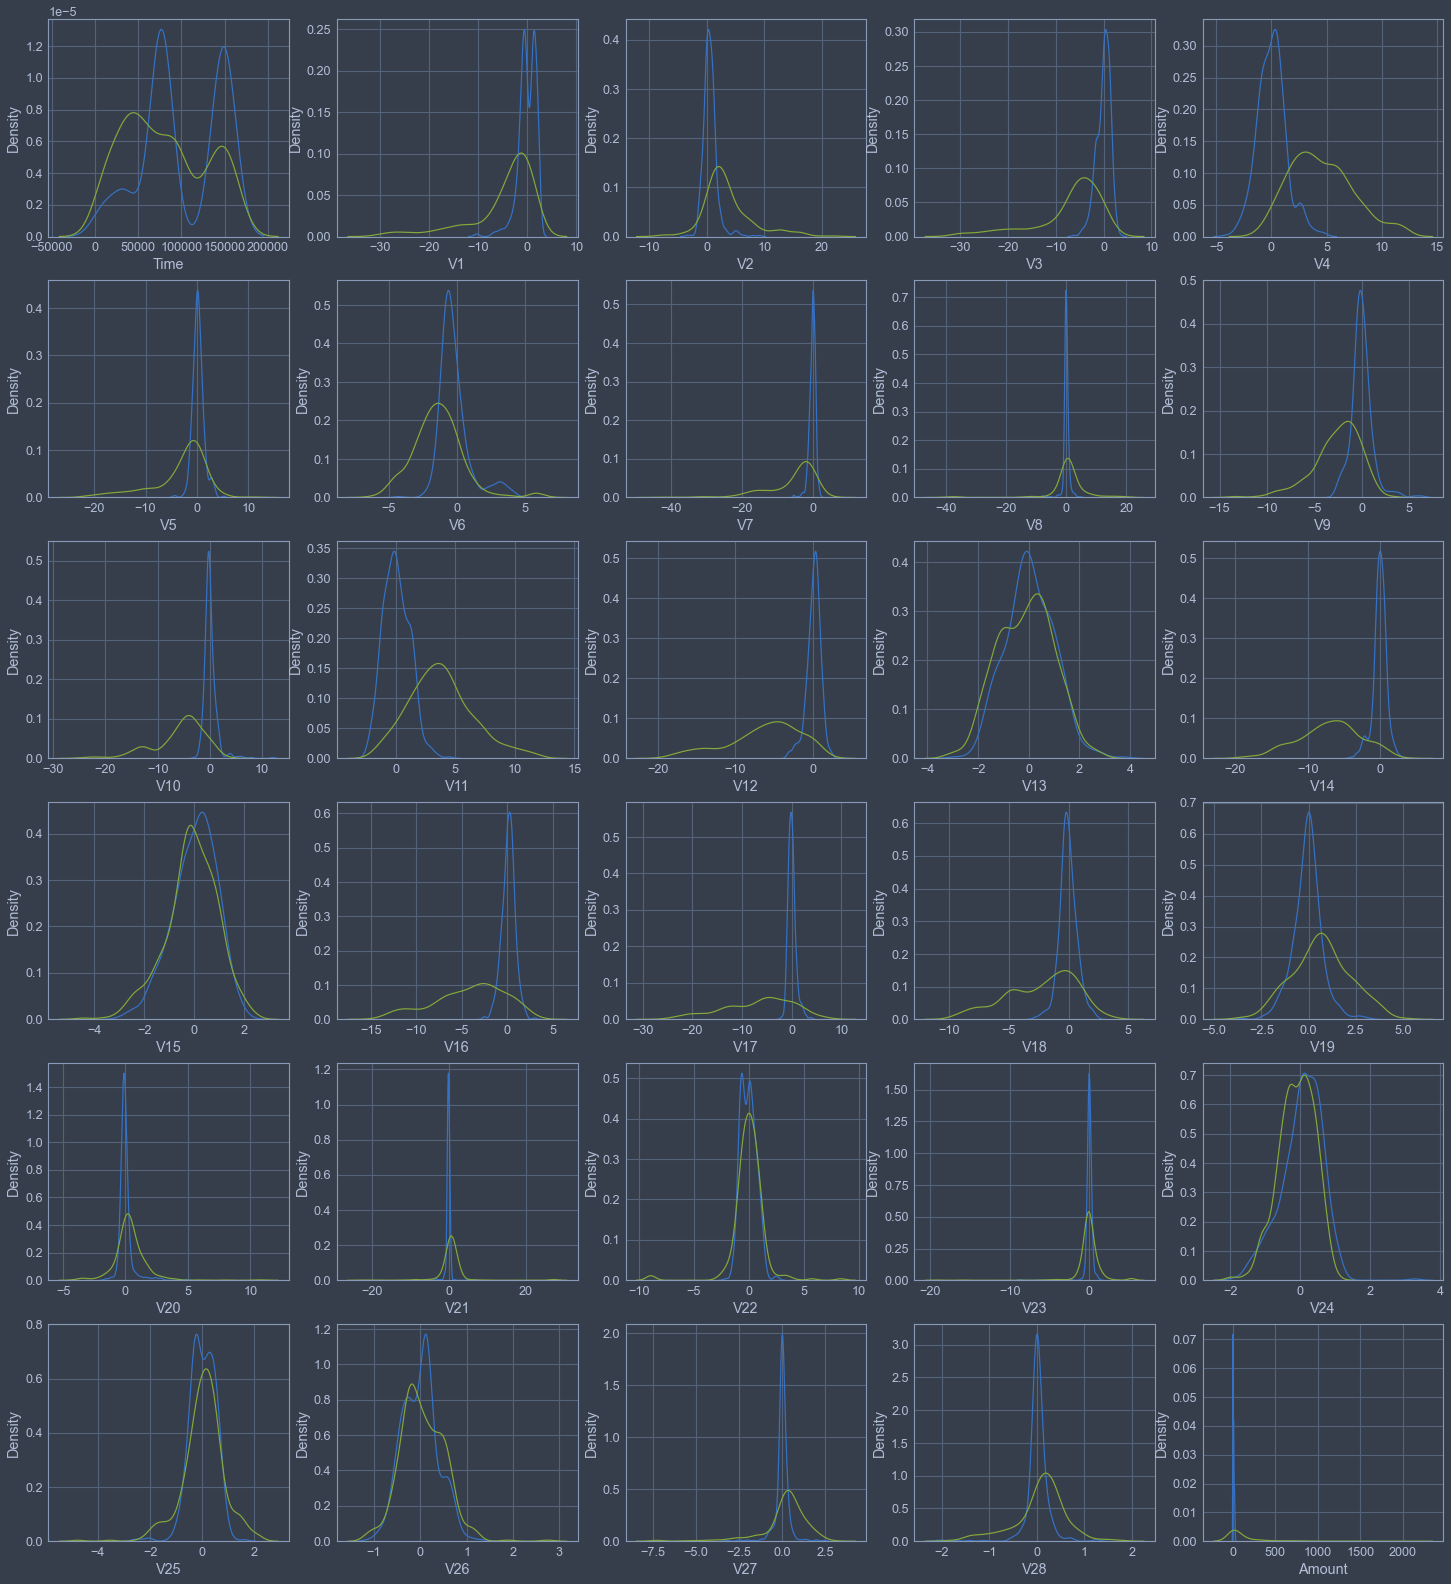

In [93]:
plt.figure()
fig, ax = plt.subplots(6,5,figsize=(25,28))
i = 1
for n in X_train.columns.values:
    plt.subplot(6,5,i)
    sns.kdeplot(normal[n],label="Normal")
    sns.kdeplot(fraud[n],label="Fraud")
    i+=1
plt.show()

After looking all 30 plots, it seems like the PCA transformed vairable have a normal distribution but not the Time and Amount columns. Let's take out those 2 columns before preceeding to build the model.

In [94]:
X_train = X_train.iloc[:,1:-1]
X_test = X_test.iloc[:,1:-1]

In [95]:
from sklearn.naive_bayes import GaussianNB

In [96]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
#train and predict the test result
predicted = gnb.predict(X_test)

In [97]:
#Cross validate to check the score
accuracy = cross_val_score(gnb, X_test, y_test, cv=3)
np.mean(accuracy)

0.9020476877619735

In [98]:
matrix = confusion_matrix(y_test, predicted)
print(matrix)

[[149   6]
 [ 25 116]]


In [99]:
report = classification_report(y_test, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       155
           1       0.95      0.82      0.88       141

    accuracy                           0.90       296
   macro avg       0.90      0.89      0.89       296
weighted avg       0.90      0.90      0.89       296



The performance of Guassian Naive Bayes is the worst out of the three model using the undersampled data.

 ### Conclusion

In conclusion, logistic regression perform the best. Sklearn provided many diffferent tools to build and measure models. From this project I learn about the proper ways to prepare imbalance data. However, having most of the variables as PCA means there are not less ways to work on feature engineering. In the future, I wish to work on imbalance data that comes with original data with proper column labels.